# Introduction

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import altair as alt
import math
from pandas import datetime
from scipy.stats import ttest_rel

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
obs_train = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/observations_train.csv')

In [ ]:
series = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/series.csv', encoding = "ISO-8859-1")

In [ ]:
results_df = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/results.csv')

In [ ]:
series.head()

,series_id,name,frequency,units,seasonal_adjustment,Description
0,AAA10Y,Moodys Seasoned Aaa Corporate Bond Yield Relat...,Daily,Percent,Not Seasonally Adjusted,Series is calculated as the spread between Moo...
1,ASEANTOT,Import Price Index: ASEAN - All commodities,Monthly,Index Dec 2003=100,Not Seasonally Adjusted,"For more information, please see the Import/Ex..."
2,BAA10Y,Moodys Seasoned Baa Corporate Bond Yield Relat...,Daily,Percent,Not Seasonally Adjusted,Series is calculated as the spread between Moo...
3,BUSAPPWNSAUS,Business Applications for the United States,"Weekly, Ending Saturday",Number,Not Seasonally Adjusted,Business Applications (BA): The core business ...
4,BUSAPPWNSAUSYY,Business Applications for the United States,"Weekly, Ending Saturday",Percent Change from Year Ago,Not Seasonally Adjusted,Business Applications (BA): The core business ...


In [ ]:
obs_test = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/obs_test.csv')

In [ ]:
#Imputing the null values of the dataset
def fillna(df):
  for i in df.index:
    if np.isnan(df['value'][i]):
      if i-1 not in df.index:
        df.at[i, 'value'] = df['value'][i+1]
      elif i+1 in df.index:
        if np.isnan(df['value'][i+1]):
          if i+2 in df.index:
            if np.isnan(df['value'][i+2]):
              df.at[i, 'value'] = (df['value'][i-1] + df['value'][i+3])/2 #needs fixing for which average to get
            else:
              df.at[i, 'value'] = (df['value'][i-1] + df['value'][i+2])/2
          else:
            df.at[i, 'value'] = df['value'][i-1]
        else:
          df.at[i, 'value'] = (df['value'][i-1] + df['value'][i+1])/2
      else:
        df.at[i, 'value'] = df['value'][i-1]
  return df
observations=obs_train

df = pd.DataFrame(columns=observations.columns)
for i in observations.series_id.unique():
  sub_df = observations[observations['series_id'] == i]
  sub_df = fillna(sub_df)
  df = df.append(sub_df)

#New imputed dataframe 
obs_train = df
obs_train['date'] = pd.to_datetime(obs_train['date'])

In [ ]:
sp = obs_train.loc[obs_train['series_id'] == 'SP500']
sp.head()

,series_id,date,value
84020,SP500,2011-02-14,1332.32
84021,SP500,2011-02-15,1328.01
84022,SP500,2011-02-16,1336.32
84023,SP500,2011-02-17,1340.43
84024,SP500,2011-02-18,1343.01


## EDA

In [ ]:
#Visualize the SP500 Values over time
scales = alt.selection_interval(bind='scales')

alt.Chart(sp).mark_line().encode(
    x='date',
    y='value'
).add_selection(scales).properties(
    width=1200,
    height=600
)
# plt.figure(figsize=(16,8))
# plt.title('SP500 Values over Time')
# plt.xlabel('Date')
# plt.ylabel('SP500 Value')
# plt.plot(sp['date'],sp['value'])
# plt.show()

alt.Chart(...)

### Creating Features

**Daily Percent Change**

In [ ]:
daily_pct_change = 100 * (sp['value'].pct_change())
daily_pct_change.head()

84020         NaN
84021   -0.323496
84022    0.625748
84023    0.307561
84024    0.192476
Name: value, dtype: float64

Plotting the daily percent change

In [ ]:
#Plotting the daily percent change
sp['pct_change'] = daily_pct_change
scales = alt.selection_interval(bind='scales')

alt.Chart(sp).mark_line().encode(
    x='date',
    y='pct_change'
).add_selection(scales).properties(
    width=800,
    height=400
)

# fig, ax = plt.subplots(figsize=(10, 5))
# plt.plot(daily_pct_change)
# plt.xlabel('Year')
# plt.ylabel('Daily Return %')
# plt.title('Simple Returns - S&P 500 Index Daily Returns over the years')
# plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


alt.Chart(...)

**Plotting the Log returns**

In [ ]:
# Daily log returns
daily_log_returns = np.log((sp['value'] / sp['value'].shift(1)))*100
sp['log_returns'] = daily_log_returns

scales = alt.selection_interval(bind='scales')

alt.Chart(sp).mark_line().encode(
    x='date',
    y='log_returns'
).add_selection(scales).properties(
    width=800,
    height=400
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


alt.Chart(...)

In [ ]:
print('Daily log returns')
print(daily_log_returns.describe())
print()
print('Daily percent change returns')
print(daily_pct_change.describe())

Daily log returns
count    1794.000000
mean        0.038824
std         0.877388
min        -6.895833
25%        -0.310537
50%         0.041594
75%         0.470672
max         4.631738
Name: value, dtype: float64

Daily percent change returns
count    1794.000000
mean        0.042674
std         0.875736
min        -6.663443
25%        -0.310055
50%         0.041602
75%         0.471781
max         4.740679
Name: value, dtype: float64


### Create the Moving Averages

In [ ]:
#Creating Exponential Moving Averages and Simple Moving Averages

#Exponential moving averages
sp['2EMA'] = sp['value'].ewm(span=2, adjust = False).mean()
sp['5EMA'] = sp['value'].ewm(span=5, adjust = False).mean()
sp['10EMA'] = sp['value'].ewm(span=10, adjust = False).mean()
sp['20EMA'] = sp['value'].ewm(span=20, adjust = False).mean()
sp['30EMA'] = sp['value'].ewm(span=30, adjust = False).mean()
sp['100EMA'] = sp['value'].ewm(span=100, adjust = False).mean()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

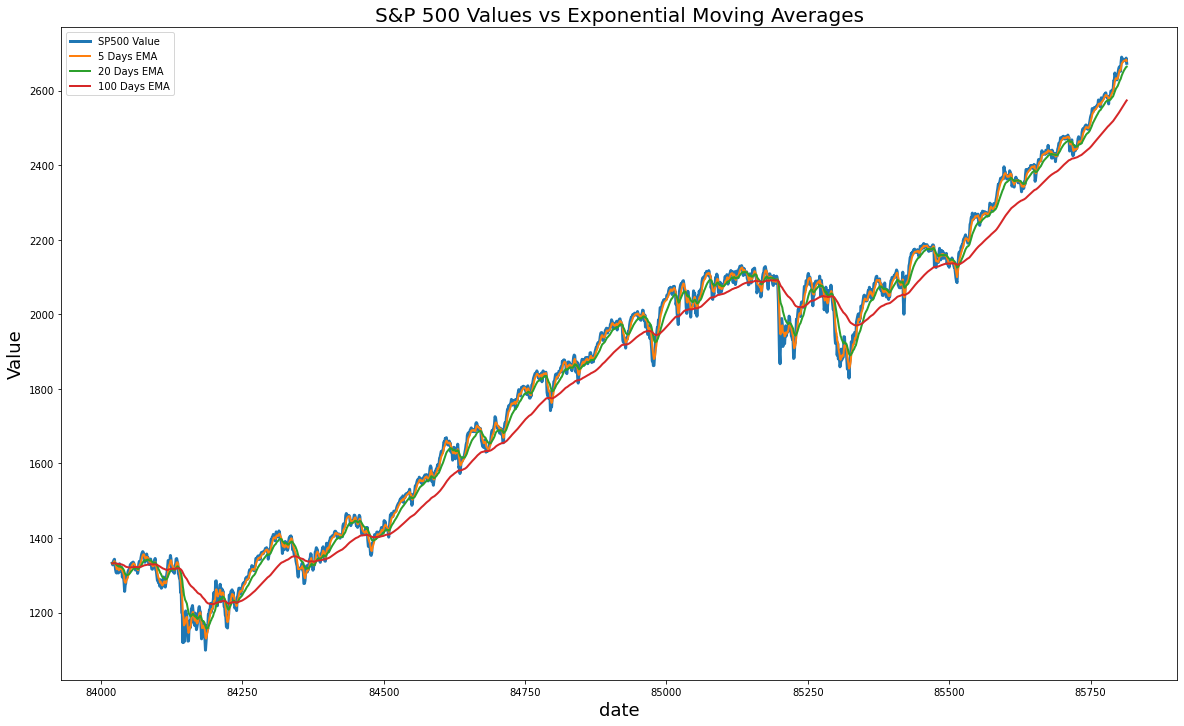

In [ ]:
#Visualize
fig, ax = plt.subplots(figsize=(20,12))
plt.title('S&P 500 Values vs Exponential Moving Averages', size=20)
plt.plot(sp['value'], label='SP500 Value', linewidth= 3)
#plt.plot(sp['2EMA'], label = '2 EMA', linewidth= 2)
plt.plot(sp['5EMA'], label = '5 Days EMA', linewidth= 2)
#plt.plot(sp['10EMA'], label = '10 EMA', linewidth= 2)
plt.plot(sp['20EMA'], label = '20 Days EMA', linewidth= 2)
#plt.plot(sp['30EMA'], label = '30 EMA', linewidth= 2)
plt.plot(sp['100EMA'], label = '100 Days EMA', linewidth= 2)

plt.xlabel('date', size = 18)
plt.ylabel('Value', size = 18)
plt.legend()
plt.show()

In [ ]:
#Interactive chart
base = alt.Chart(sp.reset_index()).encode(x='date')

alt.layer(
    base.mark_line(color='green',).encode(y='value', tooltip='value'),
    base.mark_line(color='blue').encode(y='2EMA'),
    base.mark_line(color='red').encode(y='20EMA'),
    base.mark_line(color='orange').encode(y='100EMA'), title = 'Moving Averages '
).add_selection(scales).properties(
    width=1200,
    height=600
)

alt.LayerChart(...)

## Exploring related features to the SP500
We will be taking a look at these IDs: TLAACBW027NBOG, TLBACBW027NBOG, EFFRVOL
The reason we are doing this is because we tend to see some similar patterns in the SP500 with these 3 features that could potentially help explain and predict the SP500 patterns.

In [ ]:
#Getting the train dataframe
df = obs_train
#Selecting the 
eff = df[df['series_id'] == 'EFFRVOL'].reset_index(drop = True)
obf = df[df['series_id'] == 'OBFRVOL'].reset_index(drop = True)
ta = df[df['series_id'] == 'TLBACBW027NBOG'].reset_index(drop = True)
tl = df[df['series_id'] == 'TLAACBW027NBOG'].reset_index(drop = True)

#Plotting out the feature's value over time
scales = alt.selection_interval(bind='scales')

alt.Chart(eff, title='EFFRVOL').mark_line().encode(
    x='date',
    y='value'
).add_selection(scales).properties(
    width=500,
    height=300
)

alt.Chart(...)

In [ ]:
#DAILY PERCENT CHANGE FOR EFF
daily_pct_change = 100 * (eff['value'].pct_change())
daily_pct_change
#Plotting the daily percent change
eff['pct_change'] = daily_pct_change
scales = alt.selection_interval(bind='scales')

alt.Chart(eff).mark_line().encode(
    x='date',
    y='pct_change'
).add_selection(scales).properties(
    width=800,
    height=400
)

alt.Chart(...)

In [ ]:
alt.Chart(obf, title='OBFRVOL').mark_line().encode(
    x='date',
    y='value'
).add_selection(scales).properties(
    width=500,
    height=300
)

alt.Chart(...)

In [ ]:
#DAILY PERCENT CHANGE FOR EFF
daily_pct_change = 100 * (obf['value'].pct_change())
daily_pct_change
#Plotting the daily percent change
obf['pct_change'] = daily_pct_change
scales = alt.selection_interval(bind='scales')

alt.Chart(obf).mark_line().encode(
    x='date',
    y='pct_change'
).add_selection(scales).properties(
    width=800,
    height=400
)

alt.Chart(...)

In [ ]:
alt.Chart(ta, title='TLBACBW027NBOG').mark_line().encode(
    x='date',
    y='value'
).add_selection(scales).properties(
    width=500,
    height=300
)

alt.Chart(...)

In [ ]:
#DAILY PERCENT CHANGE FOR TA
daily_pct_change = 100 * (ta['value'].pct_change())
daily_pct_change
#Plotting the daily percent change
ta['pct_change'] = daily_pct_change
scales = alt.selection_interval(bind='scales')

alt.Chart(ta).mark_line().encode(
    x='date',
    y='pct_change'
).add_selection(scales).properties(
    width=800,
    height=400
)

alt.Chart(...)

In [ ]:
def daily_pct_chng(df):
    daily_pct_change = 100 * (ta['value'].pct_change())
    return daily_pct_change

In [ ]:
alt.Chart(tl, title='TLAACBW027NBOG').mark_line().encode(
    x='date',
    y='value'
).add_selection(scales).properties(
    width=500,
    height=300
)

alt.Chart(...)

In [ ]:
#Scale all the data and plot them on the same graph
scaler = MinMaxScaler(feature_range=(0,1))

sp['scaled_val'] = scaler.fit_transform(np.array(sp.value).reshape(-1,1))
eff['scaled_val'] = scaler.fit_transform(np.array(eff.value).reshape(-1,1))
obf['scaled_val'] = scaler.fit_transform(np.array(obf.value).reshape(-1,1))
ta['scaled_val'] = scaler.fit_transform(np.array(ta.value).reshape(-1,1))
tl['scaled_val'] = scaler.fit_transform(np.array(tl.value).reshape(-1,1))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#Interactive chart
base = alt.Chart(sp.reset_index()).encode(x='date')
base2 = alt.Chart(eff.reset_index()).encode(x='date')
base3 = alt.Chart(obf.reset_index()).encode(x='date')
base4 = alt.Chart(ta.reset_index()).encode(x='date')
base5 = alt.Chart(tl.reset_index()).encode(x='date')

alt.layer(
    base.mark_line(color='green',).encode(y='scaled_val', tooltip='scaled_val'),
    base4.mark_line(color='purple').encode(y='scaled_val'),
    base5.mark_line(color='orange').encode(y='scaled_val')
).add_selection(scales).properties(
    width=1200,
    height=600
)

alt.LayerChart(...)

# Create LSTM Model


### Creating Train and Test Data for the Model

In [ ]:
#Create the data with the SP500 values
data = sp['value'].values
print(data.shape)
#Create the train data length
train_len = math.ceil(len(data) * .8)

#Create training data
train_data  = data[0:train_len]
train_data

(1795,)


array([1332.32, 1328.01, 1336.32, ..., 2185.79, 2184.05, 2190.15])

In [ ]:
#Scale training data
scaler = MinMaxScaler(feature_range=(0,1))

#Reshape data since it has only one feature
train_data = train_data.reshape(-1,1)

#Transform train data
scaled_train = scaler.fit_transform(train_data)

scaled_train

array([[0.2136637 ],
       [0.2097129 ],
       [0.21733033],
       ...,
       [0.99600337],
       [0.99440839],
       [1.        ]])

In [ ]:
#Split into X_train and y_train datasets
x_train = []
y_train = []

#Create data for week prediction
idx = 7 #7 days predictions (week)

for i in range(idx, len(train_data)):
    x_train.append(scaled_train[i-idx:i, 0])
    y_train.append(scaled_train[i, 0])

In [ ]:
#Converting x_train and y_train into numpy arrays for the input to the model
x_train, y_train = np.array(x_train), np.array(y_train)

#The shapes of the y and x train numpy arrays
print(y_train.shape)
print(x_train.shape)

(1429,)
(1429, 7)


In [ ]:
#Training parameters
timesteps = x_train.shape[1] #Number of timesteps
size = x_train.shape[0] #Number of observations
feats = 1 #Number of features

#Reshape the data into 3D array
x_train = np.reshape(x_train, (size, timesteps, feats)) 

#The x_train has 1429 rows of observations, 7 days of data being used to train, and only has 1 feature (value)
x_train.shape

(1429, 7, 1)

## LSTM Model Function

In [ ]:
def create_train_model(x_train, y_train, timesteps, feats, epochs, batch):
    '''
    Function to create the LSTM model

    x_train: input features
    y_train: the dependent variable we are predicting
    '''
    #Build the LSTM Model
    model = Sequential()

    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(50, return_sequences= True, input_shape = (timesteps, feats)))
    
    #Second LSTYM Layer
    model.add(LSTM(50, return_sequences= False))

    #Adding dense layers
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Train the model
    model.fit(x_train, y_train, batch_size=batch, epochs=epochs)

    return model

In [ ]:
#Create and fit our LSTM model
model = create_train_model(x_train, y_train, timesteps = 7, feats = 1, epochs = 2, batch = 1)

Epoch 1/2
1429/1429 [==============================] - 39s 5ms/step - loss: 0.0170
Epoch 2/2
1429/1429 [==============================] - 7s 5ms/step - loss: 0.0011


In [ ]:
#Create the testing dataset
#New testing data will contain data from index 1429 and on
test_data  = data[train_len - idx:] #

#Reshape data since it has only one feature
test_data = test_data.reshape(-1,1)

#Transform test data
scaled_test = scaler.fit_transform(test_data)

In [ ]:
#Create X_test and y_test
x_test = []
y_test = data[train_len:]

#Repeat the same process to create testing data
for i in range(idx, len(test_data)):
    x_test.append(scaled_test[i-idx:i, 0])


In [ ]:
#Convert x_test to numpy array
x_test = np.array(x_test)

In [ ]:
#Reshape the data
timesteps = x_test.shape[1] #Number of timesteps
size = x_test.shape[0] #Number of observations
feats = 1 #Number of features

x_test = np.reshape(x_test, (size, timesteps, feats))
x_test.shape

(359, 7, 1)

In [ ]:
#Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Evaluate the model using RMSE
rmse = mean_squared_error(y_test,predictions)
rmse

288.5419638168648

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


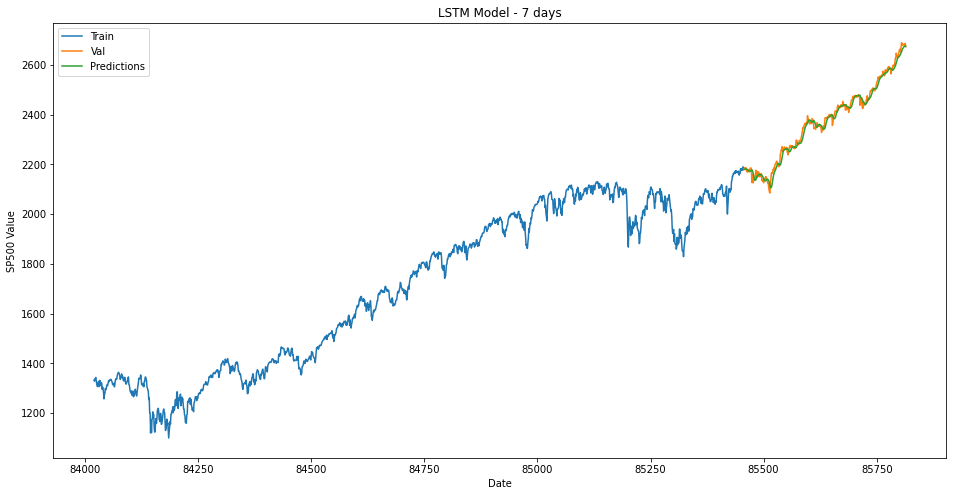

In [ ]:
#Plot the data and predictions
train = sp[:train_len]
valid = sp[train_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("LSTM Model - 7 days")
plt.xlabel('Date')
plt.ylabel('SP500 Value')
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

## Functions for Creating Train and Test Data

In [ ]:
def create_train_data(train_data, scaled_train, idx):
    '''
    Function that creates our training data in the format for the LSTM model
    from the split train data and scaled data based on a specified time prediction

    train_data: training split data
    scaled_train: training data scaled with MinMax scaler
    idx: the specified time prediction (7 days, 30 days, or 1 year)
    '''
    #Split into X_train and y_train datasets
    x_train = []
    y_train = []

    #Create data for specified time prediction (idx)
    for i in range(idx, len(train_data)):
        x_train.append(scaled_train[i-idx:i, 0])
        y_train.append(scaled_train[i, 0])

    #Converting x_train and y_train into numpy arrays for the input to the model
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Training parameters
    timesteps = x_train.shape[1] #Number of timesteps
    size = x_train.shape[0] #Number of observations
    feats = 1 #Number of features

    #Reshape the data into 3D array
    x_train = np.reshape(x_train, (size, timesteps, feats)) 

    return x_train, y_train

In [ ]:
def create_test_data(data, train_data, idx):
    '''
    Function that creates the test data for making our model predictions, scales and format the test data.

    data: The unformatted dataframe
    train_data: The training data used for the model
    idx: the specified time prediction (7 days, 30 days, or 1 year)
    '''
    
    #New testing data will contain data from index of last train data and on
    train_len = len(train_data)
    test_data  = data[train_len - idx:] #
    #Reshape data since it has only one feature
    test_data = test_data.reshape(-1,1)

    #Transform test data
    scaled_test = scaler.fit_transform(test_data)
    #Create X_test and y_test
    x_test = []
    y_test = data[train_len:]

    #Repeat the same process to create testing data
    for i in range(idx, len(test_data)):
        x_test.append(scaled_test[i-idx:i, 0])
        
    #Convert x_test to numpy array
    x_test = np.array(x_test)

    #Reshape the data
    timesteps = x_test.shape[1] #Number of timesteps
    size = x_test.shape[0] #Number of observations
    feats = 1 #Number of features

    x_test = np.reshape(x_test, (size, timesteps, feats))

    return x_test, y_test

# LSTM Model Tuning

In [ ]:
#Call the function to create training datasets x_train and y_train
x_train, y_train = create_train_data(train_data, scaled_train, idx=30)

In [ ]:
#Call the function to create test datasets x_test and y_test
x_test, y_test = create_test_data(data, train_data, idx=30)

In [ ]:
#Create our model for 30 days time prediction
model = create_train_model(x_train, y_train, timesteps=30, feats = 1, epochs = 2, batch = 1)

Epoch 1/2
1406/1406 [==============================] - 19s 11ms/step - loss: 0.0085
Epoch 2/2
1406/1406 [==============================] - 16s 11ms/step - loss: 0.0015


In [ ]:
#Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Evaluate the model using RMSE
rmse = mean_squared_error(y_test,predictions)
rmse

381.645878132632

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


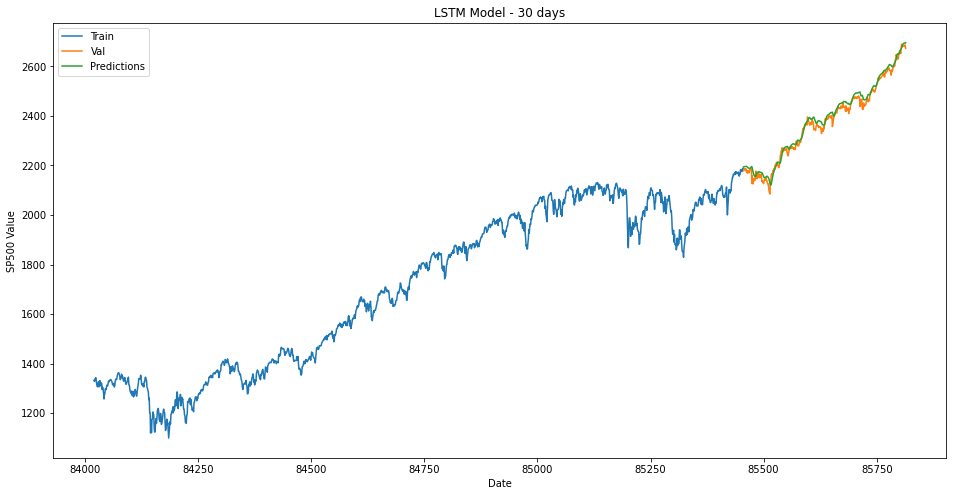

In [ ]:
#Plot the data and predictions
train = sp[:train_len]
valid = sp[train_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("LSTM Model - 30 days")
plt.xlabel('Date')
plt.ylabel('SP500 Value')
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

## Hyperparameters Tuning
To tune our hyperparameters we will be attempting to tune the different timesteps as input into the model as well as the batch size

In [ ]:
timestep = 0
batch_size = 0
rmse = 1
"RMSE: " + str(rmse)
#"Timestep: {0}", "Batch Size: {1}".format(str(timestep), str(batch_size))

'RMSE: 1'

In [ ]:
timesteps = [2,3,7,15,30,90]
batch_sizes = [1,2,3,5,7,15]
repetition = 3
results = []

#Initial hyperparameters
timestep = timesteps[0]
batch_size = batch_sizes[0]

#Loop through the models
for i in range(repetition):
    t = 0
    b = 0
    
    while t < len(timesteps):
        timestep = timesteps[t]
        
        while b < len(batch_sizes):
            batch_size = batch_sizes[b]
            #Fit model
            x_train, y_train = create_train_data(train_data, scaled_train, idx=timestep)
            x_test, y_test = create_test_data(data, train_data, idx=timestep)
            model = create_train_model(x_train, y_train, timesteps=timestep, feats = 1, epochs = 3, batch=batch_size)
            predictions = model.predict(x_test)
            predictions = scaler.inverse_transform(predictions)

            #Append result
            rmse = mean_squared_error(y_test,predictions)
            result = [timestep, batch_size, "RMSE: " + str(rmse), "Timestep: {0}, Batch Size: {1}".format(str(timestep), str(batch_size))]
            results.append(result)
            print(result)

            b += 1

        t += 1
        b = 0


Epoch 1/3
1434/1434 [==============================] - 9s 4ms/step - loss: 0.0246
Epoch 2/3
1434/1434 [==============================] - 6s 4ms/step - loss: 6.4746e-04
Epoch 3/3
1434/1434 [==============================] - 6s 4ms/step - loss: 5.7410e-04
[2, 1, 'RMSE: 163.09206617323528', 'Timestep: 2, Batch Size: 1']
Epoch 1/3
717/717 [==============================] - 6s 4ms/step - loss: 0.0369
Epoch 2/3
717/717 [==============================] - 3s 4ms/step - loss: 4.4574e-04
Epoch 3/3
717/717 [==============================] - 3s 5ms/step - loss: 4.6790e-04
[2, 2, 'RMSE: 265.54252489097286', 'Timestep: 2, Batch Size: 2']
Epoch 1/3
478/478 [==============================] - 5s 4ms/step - loss: 0.0555
Epoch 2/3
478/478 [==============================] - 2s 4ms/step - loss: 5.4677e-04
Epoch 3/3
478/478 [==============================] - 2s 4ms/step - loss: 4.7835e-04
[2, 3, 'RMSE: 188.3939650345651', 'Timestep: 2, Batch Size: 3']
Epoch 1/3
287/287 [==============================] - 5s 

In [ ]:
results_df = pd.DataFrame(results, columns = ['Timestep', 'Batch Size', 'RMSE', 'Summary'])
results_df['RMSE'] = results_df['RMSE'].apply(lambda x : float(x.split(' ')[1]))

In [ ]:
results_df

,Unnamed: 0,Timestep,Batch Size,RMSE,Summary
0,0,2,1,352.742568,"Timestep: 2, Batch Size: 1"
1,1,2,2,192.716992,"Timestep: 2, Batch Size: 2"
2,2,2,3,172.997232,"Timestep: 2, Batch Size: 3"
3,3,2,5,164.422477,"Timestep: 2, Batch Size: 5"
4,4,2,7,175.361862,"Timestep: 2, Batch Size: 7"
...,...,...,...,...,...
103,103,90,2,431.050030,"Timestep: 90, Batch Size: 2"
104,104,90,3,453.020504,"Timestep: 90, Batch Size: 3"
105,105,90,5,712.102690,"Timestep: 90, Batch Size: 5"
106,106,90,7,357.620643,"Timestep: 90, Batch Size: 7"


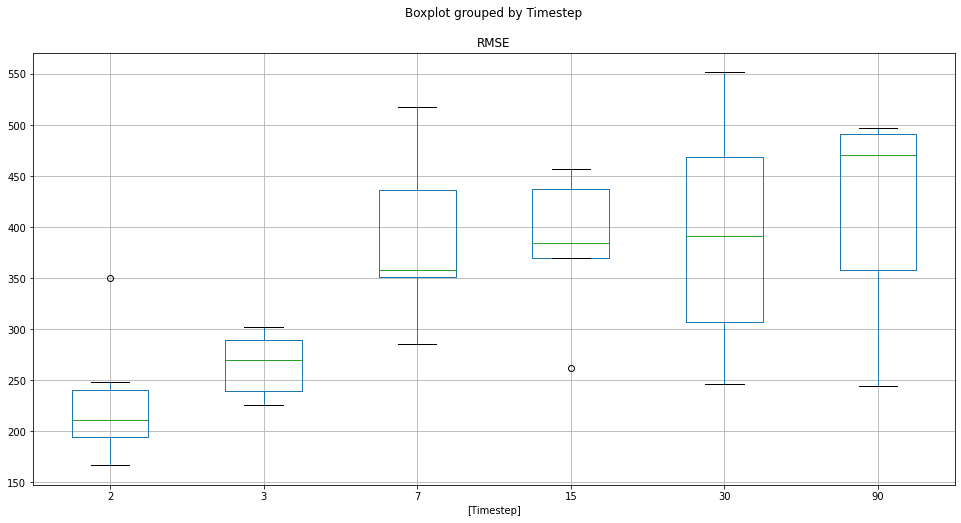

In [ ]:
#Results of the hyperparameter tuning
results_df.groupby(['Timestep', 'Batch Size']).mean().boxplot(by='Timestep', figsize=(16,8))

In [ ]:
#Pivot Table of Results
results = results_df.groupby(['Timestep', 'Batch Size']).mean()

RMSE
Timestep Batch Size            
2        1           349.843656
         2           217.335732
         3           191.670447
         5           166.922652
         7           204.013902
         15          248.506883
3        1           285.208636
         2           290.477508
         3           302.145369
         5           225.390058
         7           233.647895
         15          255.345264
7        1           285.538114
         2           517.938677
         3           349.701080
         5           360.905966
         7           461.034798
         15          355.704220
15       1           261.932449
         2           450.961161
         3           369.439970
         5           372.620712
         7           397.239230
         15          457.418304
30       1           246.126992
         2           299.213607
         3           332.254909
         5           551.549310
         7           475.233691
         15          451.173530
90       1           244.521014
         2           322.509936
         3           497.571464
         5           464.428685
         7           477.599182
         15          495.352145

Hypothesis/t-Testing

First comparing batch sizes and testing for significance

In [ ]:
results = results_df.groupby(['Timestep', 'Batch Size']).mean()
results['batch_size'] = 0
results['timestep'] = 0
for index, row in results.iterrows():
  results.at[index,'batch_size'] = index[1]
  results.at[index, 'timestep'] = index[0]

In [ ]:
batch_size1 = []
batch_size2 = []
batch_size3 = []
batch_size5 = []
batch_size7 = []
batch_size15 = []

for index,row in results.iterrows():
  if row['batch_size'] == 1:
    batch_size1.append(row['RMSE'])
  elif row['batch_size'] == 2:
    batch_size2.append(row['RMSE'])
  elif row['batch_size'] == 3:
    batch_size3.append(row['RMSE'])
  elif row['batch_size'] == 5:
    batch_size5.append(row['RMSE'])
  elif row['batch_size'] == 7:
    batch_size7.append(row['RMSE'])
  else:
    batch_size15.append(row['RMSE'])

In [ ]:
print(ttest_rel(batch_size1, batch_size2))
print(ttest_rel(batch_size1, batch_size3))
print(ttest_rel(batch_size1, batch_size5))
print(ttest_rel(batch_size1, batch_size7))
print(ttest_rel(batch_size1, batch_size15))
print(ttest_rel(batch_size2, batch_size3))
print(ttest_rel(batch_size2, batch_size5))
print(ttest_rel(batch_size2, batch_size7))
print(ttest_rel(batch_size2, batch_size15))
print(ttest_rel(batch_size3, batch_size5))
print(ttest_rel(batch_size3, batch_size7))
print(ttest_rel(batch_size3, batch_size15))
print(ttest_rel(batch_size5, batch_size7))
print(ttest_rel(batch_size5, batch_size15))
print(ttest_rel(batch_size7, batch_size15))

Ttest_relResult(statistic=-1.323128322471095, pvalue=0.24306826887299454)
Ttest_relResult(statistic=-1.1267997630349407, pvalue=0.31098123385903054)
Ttest_relResult(statistic=-1.0695083644235515, pvalue=0.33373073680154314)
Ttest_relResult(statistic=-1.4884015977317573, pvalue=0.19681295788763542)
Ttest_relResult(statistic=-1.694186407849833, pvalue=0.15100429566410625)
Ttest_relResult(statistic=0.1963234444928633, pvalue=0.8520870568951966)
Ttest_relResult(statistic=-0.11380974070650847, pvalue=0.9138172655737269)
Ttest_relResult(statistic=-0.5565551362066125, pvalue=0.6018206280268754)
Ttest_relResult(statistic=-0.5430449322346991, pvalue=0.6104215646188171)
Ttest_relResult(statistic=-0.3883482373568622, pvalue=0.7137432904873621)
Ttest_relResult(statistic=-1.054757168641105, pvalue=0.3398137653411153)
Ttest_relResult(statistic=-1.453190680816502, pvalue=0.20590474099188463)
Ttest_relResult(statistic=-0.7678598595202593, pvalue=0.4772476343261355)
Ttest_relResult(statistic=-0.7271725

Comparing Timesteps and checking them for significance

In [ ]:
timestep2 = []
timestep3 = []
timestep7 = []
timestep15 = []
timestep30 = []
timestep90 = []

for index,row in results.iterrows():
  if row['timestep'] == 2:
    timestep2.append(row['RMSE'])
  elif row['timestep'] == 3:
    timestep3.append(row['RMSE'])
  elif row['timestep'] == 7:
    timestep7.append(row['RMSE'])
  elif row['timestep'] == 15:
    timestep15.append(row['RMSE'])
  elif row['timestep'] == 30:
    timestep30.append(row['RMSE'])
  else:
    timestep90.append(row['RMSE'])

In [ ]:
print(ttest_rel(timestep2, timestep3))
print(ttest_rel(timestep2, timestep7))
print(ttest_rel(timestep2, timestep15))
print(ttest_rel(timestep2, timestep30))
print(ttest_rel(timestep2, timestep90))
print(ttest_rel(timestep3, timestep7))
print(ttest_rel(timestep3, timestep15))
print(ttest_rel(timestep3, timestep30))
print(ttest_rel(timestep3, timestep90))
print(ttest_rel(timestep7, timestep15))
print(ttest_rel(timestep7, timestep30))
print(ttest_rel(timestep7, timestep90))
print(ttest_rel(timestep15, timestep30))
print(ttest_rel(timestep15, timestep90))
print(ttest_rel(timestep30, timestep90))

Ttest_relResult(statistic=-1.43775239633262, pvalue=0.21001672701577243)
Ttest_relResult(statistic=-3.0103672822852077, pvalue=0.02974307209238584)
Ttest_relResult(statistic=-3.15433709360556, pvalue=0.025255422128967777)
Ttest_relResult(statistic=-2.3789690395558365, pvalue=0.06324567926348608)
Ttest_relResult(statistic=-2.8496723834632727, pvalue=0.035837489113809844)
Ttest_relResult(statistic=-3.243335059220713, pvalue=0.022864404172155482)
Ttest_relResult(statistic=-3.5349752360750317, pvalue=0.016651339477155056)
Ttest_relResult(statistic=-2.1156015556924426, pvalue=0.08799474408327967)
Ttest_relResult(statistic=-2.989390853284086, pvalue=0.030468681624124905)
Ttest_relResult(statistic=0.1372232420276923, pvalue=0.8962088663354986)
Ttest_relResult(statistic=-0.07314256896348044, pvalue=0.9445285229764198)
Ttest_relResult(statistic=-0.5286610520970659, pvalue=0.6196575975899441)
Ttest_relResult(statistic=-0.16782288124396547, pvalue=0.8732995114438791)
Ttest_relResult(statistic=-0.

From our tuning, we ran the model with the following hyperparameters 3 times and got the average of the RMSE of the iterations. We see that the best model is using the following hyperparameters timestep of 2 and a batch size of 5.

In [ ]:
#Use the model with the best hyperparameters
x_train, y_train = create_train_data(train_data, scaled_train, idx=2)
x_test, y_test = create_test_data(data, train_data, idx=2)
model = create_train_model(x_train, y_train, timesteps=2, feats = 1, epochs = 3, batch=5)

Epoch 1/3
287/287 [==============================] - 5s 6ms/step - loss: 0.0796
Epoch 2/3
287/287 [==============================] - 2s 6ms/step - loss: 5.0160e-04
Epoch 3/3
287/287 [==============================] - 2s 6ms/step - loss: 4.1399e-04


In [ ]:
#Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = mean_squared_error(y_test,predictions)
rmse


162.58148054712723

array([[0.163427],
       [0.17351 ]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


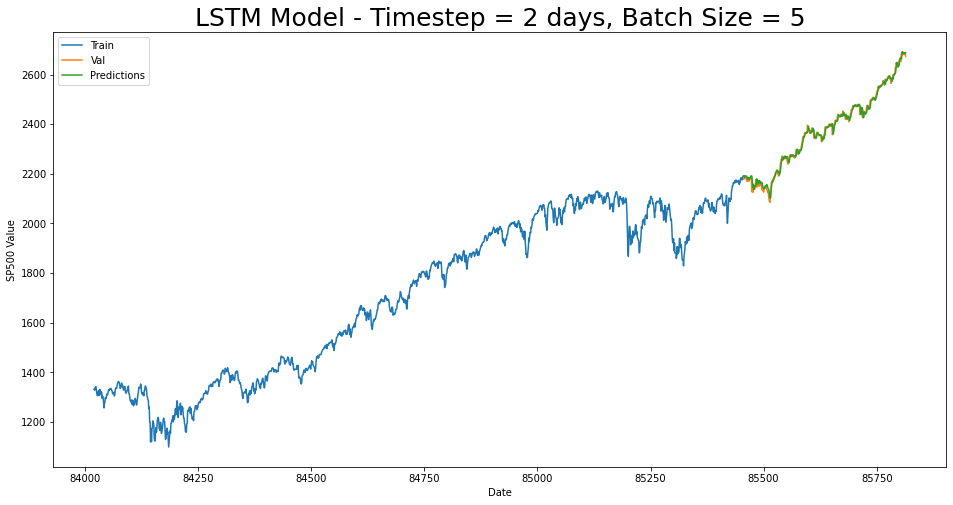

In [ ]:
#Plot the data and predictions
train = sp[:train_len]
valid = sp[train_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("LSTM Model - Timestep = 2 days, Batch Size = 5", size = 25)
plt.xlabel('Date')
plt.ylabel('SP500 Value')
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])


# Testing out LSTM model to predict a stock price on an unknown day

In [ ]:
def transform_data_test_model(data, idx):
    

    #Reshape data since it has only one feature
    test_data = data

    #Transform test data
    scaler = scaler = MinMaxScaler(feature_range=(0,1))
    test_data_x = np.array(test_data.value).reshape(-1,1)
    scaled_test = scaler.fit_transform(test_data_x)

    #Create X_test and y_test
    x_test = []
    #y_test = data[train_len:]

    #Repeat the same process to create testing data
    for i in range(idx, len(test_data)):
        x_test.append(scaled_test[i-idx:i, 0])
        
    #Convert x_test to numpy array
    x_test = np.array(x_test)
    #y_test = data[train_len:]
    
    #Reshape the data
    timesteps = x_test.shape[1] #Number of timesteps
    size = x_test.shape[0] #Number of observations
    feats = 1 #Number of features

    X_test = np.reshape(x_test, (size, timesteps, feats))

    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)

    return pred_price

In [ ]:
#Get the test data and impute missing values
observations=obs_test

df = pd.DataFrame(columns=observations.columns)
for i in observations.series_id.unique():
  sub_df = observations[observations['series_id'] == i]
  sub_df = fillna(sub_df)
  df = df.append(sub_df)

#New imputed dataframe 
obs_test = df

#Pickout the SP500 values
test_df = obs_test[obs_test['series_id'] == 'SP500']
test_df = test_df['value']

#Specify how many days the data goes back
days = 7
data = obs_test[obs_test['series_id'] == 'SP500'][-days:-1]

#Run the prediction
prediction = transform_data_test_model(data, 2)
value_pred = prediction[-1][0]
print(value_pred)

3914.8381


In [ ]:
#Print the actual value
obs_test[obs_test['series_id'] == 'SP500'].iloc[-1]['value']

3916.38

# Testing the Model on the given Test Dates

In [ ]:
one = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/Vulcan_Advanced March_6_2020 Year - Sheet1.csv')
one.loc[one['series_id'] == "SP500"]

,series_id,date,value
15,SP500,01-02-18,2695.81
41,SP500,01-03-18,2713.06
60,SP500,01-04-18,2723.99
78,SP500,01-05-18,2743.15
120,SP500,01-08-18,2747.71
...,...,...,...
17223,SP500,02-28-20,2954.22
17280,SP500,03-02-20,3090.23
17328,SP500,3-3-20,3003.37
17351,SP500,3-4-20,3130.12


In [ ]:
second_year

,series_id,date,value
20541,SP500,2018-10-12,2767.13
20542,SP500,2018-10-15,2750.79
20543,SP500,2018-10-16,2809.92
20544,SP500,2018-10-17,2809.21
20545,SP500,2018-10-18,2768.78
...,...,...,...
20901,SP500,2020-02-28,2954.22
20902,SP500,2020-03-02,3090.23
20903,SP500,2020-03-03,3003.37
20904,SP500,2020-03-04,3130.12


In [ ]:
data = obs_test[obs_test['series_id'] == 'SP500']
data['date']  = pd.to_datetime(data['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,series_id,date,value
20338,SP500,2018-01-02,2695.81
20339,SP500,2018-01-03,2713.06
20340,SP500,2018-01-04,2723.99
20341,SP500,2018-01-05,2743.15
20342,SP500,2018-01-08,2747.71
...,...,...,...
21146,SP500,2021-02-05,3886.83
21147,SP500,2021-02-08,3915.59
21148,SP500,2021-02-09,3911.23
21149,SP500,2021-02-10,3909.88


In [ ]:
jan10_1month = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jan10_1month.gsheet')
jan10_1year = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jan10_1year.gsheet')
jan10_1week = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jan10_1week.gsheet')
jul12_1month = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jul12_1month.gsheet')
jul12_1year = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jul12_1year.gsheet')
jul12_1week = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/jul12_1week.gsheet')
mar6_1month = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/mar6_1month.gsheet')
mar6_1year = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/mar6_1year.gsheet')
mar6_1week = pd.read_csv('/content/drive/MyDrive/Data Hacks Folder/mar6_1week.gsheet')


In [ ]:
first_date = data.loc[data['date'] == '2020-01-10'].index[0]
second_date = data.loc[data['date'] == '2020-03-06'].index[0]
third_date = data.loc[data['date'] == '2019-07-12'].index[0]

#Create the week data
first_week = data.loc[first_date-7:first_date-1]
second_week = data.loc[second_date-7:second_date-1]
third_week = data.loc[third_date-7:third_date-1]

#Create the month data
first_month = data.loc[first_date-30:first_date-1]
second_month = data.loc[second_date-30:second_date-1]
third_month = data.loc[third_date-30:third_date-1]

#Create the year data
first_year = data.loc[first_date-365:first_date-1]
second_year = data.loc[second_date-365:second_date-1]
third_year = data.loc[third_date-365:third_date-1]

# Run this Cell For the Testing
Just change the input data, keep everything else the same

In [ ]:
first_week_pred = transform_data_test_model(first_week, 2)[-1][0]
second_week_pred = transform_data_test_model(second_week, 2)[-1][0]
third_week_pred = transform_data_test_model(third_week, 2)[-1][0]

first_month_pred = transform_data_test_model(first_month, 2)[-1][0]
second_month_pred = transform_data_test_model(second_month, 2)[-1][0]
third_month_pred = transform_data_test_model(third_month, 2)[-1][0]

first_year_pred = transform_data_test_model(first_year, 2)[-1][0]
second_year_pred = transform_data_test_model(second_year, 2)[-1][0]
third_year_pred = transform_data_test_model(third_year, 2)[-1][0]


## Final Outputs

In [ ]:
print(first_week_pred)
print(second_week_pred)
print(third_week_pred)


3242.5962
3043.9468
2983.9988


In [ ]:
print(first_month_pred)
print(second_month_pred)
print(third_month_pred)

3242.7969
3047.111
2985.4553


In [ ]:
print(first_year_pred)
print(second_year_pred)
print(third_year_pred)

3248.5598
3044.2537
2988.549


In [ ]:
print('Predicted Value 1week : 3242.5962', 'Actual Value: 3265.35')
print('Predicted Value 1week : 3043.9468', 'Actual Value: 2972.37')
print('Predicted Value 1week : 3242.5962', 'Actual Value: 3013.77')
print('Predicted Value 1month : 3242.7969', 'Actual Value: 3265.35')
print('Predicted Value 1month : 3047.111', 'Actual Value: 2972.37')
print('Predicted Value 1month : 2985.4553', 'Actual Value: 3013.77')
print('Predicted Value 1year : 3248.5598', 'Actual Value: 3265.35')
print('Predicted Value 1year : 3044.2537', 'Actual Value: 2972.37')
print('Predicted Value 1year : 2988.549', 'Actual Value: 3013.77')

Predicted Value 1week : 3242.5962 Actual Value: 3265.35
Predicted Value 1week : 3043.9468 Actual Value: 2972.37
Predicted Value 1week : 3242.5962 Actual Value: 3013.77
Predicted Value 1month : 3242.7969 Actual Value: 3265.35
Predicted Value 1month : 3047.111 Actual Value: 2972.37
Predicted Value 1month : 2985.4553 Actual Value: 3013.77
Predicted Value 1year : 3248.5598 Actual Value: 3265.35
Predicted Value 1year : 3044.2537 Actual Value: 2972.37
Predicted Value 1year : 2988.549 Actual Value: 3013.77


In [ ]:
#Make CSV file for predictions
output_dataframe = pd.DataFrame([[first_week_pred, second_week_pred, third_week_pred], [first_month_pred, second_month_pred, third_month_pred], [first_year_pred, second_year_pred, third_year_pred]], columns = ['2020-01-10', '2020-03-06', '2019-07-12'], index= ['Week', 'Month', 'Year'])
#output_dataframe.to_csv('/content/drive/MyDrive/Data Hacks Folder/final_predictions.csv')

# Facebook Prophet Model

In [ ]:
import fbprophet as prophet

train_df = sp[['value', 'date']][:train_len]
train_df = train_df.rename(columns={'date':'ds','value':'y'})
test_df = sp[['value', 'date']][train_len:]
test_df = test_df.rename(columns={'date':'ds','value':'y'})

In [ ]:
# prepare the required dataframe

In [ ]:
# Prophet model
pro_model = prophet.Prophet(daily_seasonality=True)
pro_model.fit(train_df)
#Create future dataframe
test_dates = pro_model.make_future_dataframe(periods=test_df.shape[0])
#Forecast the data using the model
forecast_df = pro_model.predict(test_dates)

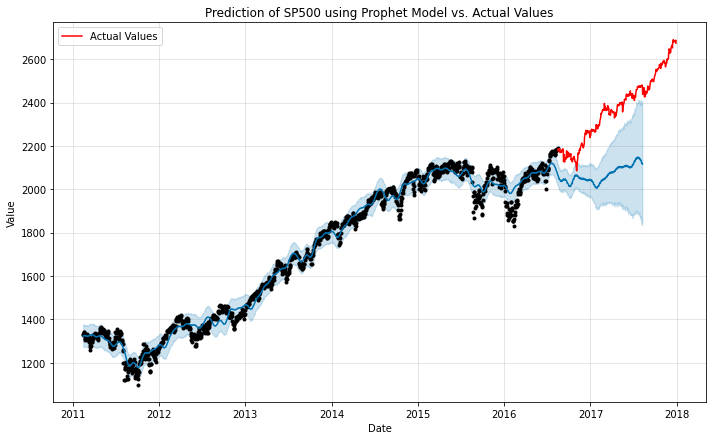

In [ ]:
pro_model.plot(forecast_df)

plt.title("Prediction of SP500 using Prophet Model vs. Actual Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.plot(test_df.set_index('ds'), label="Actual Values", color='red')
plt.legend()
plt.show()

In [ ]:
test_predictions = forecast_df[-test_df.shape[0]:]['yhat'].values

In [ ]:
rmse_prophet = mean_squared_error(test_df['y'],test_predictions)
rmse_prophet

110093.19589650267

In conclusion the prophet model attempt was not as accurate in predicting the future stock prices of the testing/validation data

# XGBoost Model

In [ ]:
#Creating the train and test data
#Create the train data length
train_len = math.ceil(len(sp) * .8)

#Scale train and test values
scaler = StandardScaler()
sp['scaled_val'] = scaler.fit_transform(np.array(sp['value']).reshape(-1,1))

df_train = sp[0:train_len]
df_test = sp[train_len:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# df_train['scaled_val'] = scaler.fit_transform(np.array(df_train['value']).reshape(-1,1))
# df_test['scaled_val'] = scaler.fit_transform(np.array(df_test['value']).reshape(-1,1))

## Engineering Features for the Model

In [ ]:
from fastai.tabular import add_datepart

#Creating features out of the date column
add_datepart(df_train, 'date', drop=False)
df_train.drop('Elapsed', axis=1, inplace=True)  # don't need this

add_datepart(df_test, 'date', drop=False)
df_test.drop('Elapsed', axis=1, inplace=True) 

sp['2EMA_scaled'] = scaler.fit_transform(np.array(sp['2EMA']).reshape(-1,1))
sp['20EMA_scaled'] = scaler.fit_transform(np.array(sp['20EMA']).reshape(-1,1))
sp['100EMA_scaled'] = scaler.fit_transform(np.array(sp['100EMA']).reshape(-1,1))

def feat_eng(sp):
    scaler = StandardScaler()
    sp['scaled_val'] = scaler.fit_transform(np.array(sp['value']).reshape(-1,1))

    daily_pct_change = 100 * (sp['value'].pct_change())
    sp['pct_change'] = daily_pct_change
    
    #Creating features out of the date column
    add_datepart(sp, 'date', drop=False)
    sp.drop('Elapsed', axis=1, inplace=True)  # don't need this
    sp['2EMA'] = sp['value'].ewm(span=2, adjust = False).mean()
    sp['20EMA'] = sp['value'].ewm(span=20, adjust = False).mean()
    sp['100EMA'] = sp['value'].ewm(span=100, adjust = False).mean()

    sp['2EMA_scaled'] = scaler.fit_transform(np.array(sp['2EMA']).reshape(-1,1))
    sp['20EMA_scaled'] = scaler.fit_transform(np.array(sp['20EMA']).reshape(-1,1))
    sp['100EMA_scaled'] = scaler.fit_transform(np.array(sp['100EMA']).reshape(-1,1))


/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_train

,series_id,date,value,pct_change,log_returns,2EMA,5EMA,10EMA,20EMA,30EMA,100EMA,scaled_val,2EMA_scaled,20EMA_scaled,100EMA_scaled,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
84020,SP500,2011-02-14,1332.32,NaN,NaN,1332.320000,1332.320000,1332.320000,1332.320000,1332.320000,1332.320000,-1.283074,-1.282946,-1.277955,-1.248512,2011,2,7,14,0,45,False,False,False,False,False,False
84021,SP500,2011-02-15,1328.01,-0.323496,-0.324020,1329.446667,1330.883333,1331.536364,1331.909524,1332.041935,1332.234653,-1.293944,-1.290197,-1.279001,-1.248737,2011,2,7,15,1,46,False,False,False,False,False,False
84022,SP500,2011-02-16,1336.32,0.625748,0.623799,1334.028889,1332.695556,1332.406116,1332.329569,1332.317940,1332.315551,-1.272986,-1.278633,-1.277931,-1.248524,2011,2,7,16,2,47,False,False,False,False,False,False
84023,SP500,2011-02-17,1340.43,0.307561,0.307089,1338.296296,1335.273704,1333.865004,1333.101039,1332.841298,1332.476234,-1.262621,-1.267864,-1.275966,-1.248101,2011,2,7,17,3,48,False,False,False,False,False,False
84024,SP500,2011-02-18,1343.01,0.192476,0.192291,1341.438765,1337.852469,1335.527730,1334.044749,1333.497344,1332.684823,-1.256114,-1.259934,-1.273562,-1.247553,2011,2,7,18,4,49,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85451,SP500,2016-08-09,2181.74,0.038975,0.038967,2180.973076,2176.731552,2172.195440,2161.199269,2149.658790,2097.362832,0.859156,0.858714,0.833395,0.764438,2016,8,32,9,1,222,False,False,False,False,False,False
85452,SP500,2016-08-10,2175.49,-0.286469,-0.286880,2177.317692,2176.317701,2172.794451,2162.560291,2151.325320,2098.909905,0.843393,0.849489,0.836862,0.768508,2016,8,32,10,2,223,False,False,False,False,False,False
85453,SP500,2016-08-11,2185.79,0.473457,0.472339,2182.965897,2179.475134,2175.157278,2164.772644,2153.548848,2100.630303,0.869370,0.863743,0.842497,0.773035,2016,8,32,11,3,224,False,False,False,False,False,False
85454,SP500,2016-08-12,2184.05,-0.079605,-0.079637,2183.688632,2181.000089,2176.774137,2166.608583,2155.516664,2102.282178,0.864982,0.865567,0.847174,0.777381,2016,8,32,12,4,225,False,False,False,False,False,False


## Modeling

In [ ]:
#Train and fit model
X = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'pct_change', '2EMA_scaled', '20EMA_scaled', '100EMA_scaled']
X_train = df_train[X]
y_train = df_train['scaled_val']
X_test = df_test[X]
y_test = df_test['value']

In [ ]:
seed=100
n_estimators=100
max_depth=3
learning_rate=0.1
min_child_weight=1
subsample=1
colsample_bytree=1
colsample_bylevel=1
gamma=0
reg = xgb.XGBRegressor(objective ='reg:squarederror',
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
y_predict = reg.predict(X_test)
y_predict

array([2174.6753, 2182.1616, 2183.3274, 2182.243 , ..., 2183.0042, 2182.9883, 2183.7373, 2176.4556], dtype=float32)

In [ ]:
print('score: ', reg.score(X_test, y_test))
print('mse: ', mean_squared_error(y_test, y_predict))
print('mae: ', mean_absolute_error(y_test, y_predict))

score:  -1.5462729009494192
mse:  60608.33041992105
mae:  198.61979560193245


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


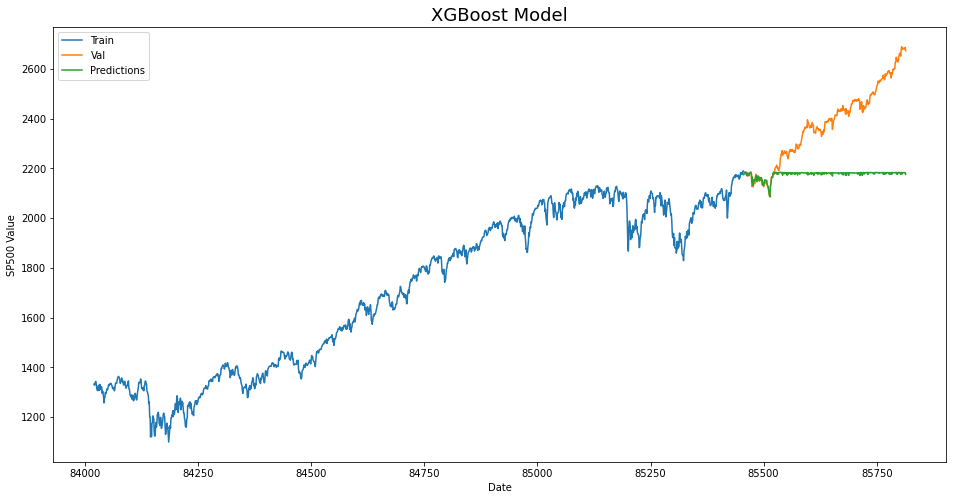

In [ ]:
#Make predictions on the validation set
y_train = sp[:train_len].value
valid = sp[train_len:]
valid['Predictions'] = y_predict

#Plot the data and predictions
plt.figure(figsize=(16,8))
plt.title("XGBoost Model", size = 18)
plt.xlabel('Date')
plt.ylabel('SP500 Value')

plt.plot(y_train)
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])

In [ ]:
#Tune the hyperparameters


In [ ]:
#Make predictions with tuned hyperparameters and test on Test data
#Get the test data and impute missing values
observations=obs_test

df = pd.DataFrame(columns=observations.columns)
for i in observations.series_id.unique():
  sub_df = observations[observations['series_id'] == i]
  sub_df = fillna(sub_df)
  df = df.append(sub_df)

#New imputed dataframe 
obs_test = df

#Pickout the SP500 values
test_df = obs_test[obs_test['series_id'] == 'SP500']

#Get the last 30 days
last_30_days = test_df[-31:-1]
#last_30_days = last_30_days.reshape(-1,1)

#Scale the data
#last_30_days_scaled = scaler.fit_transform(last_30_days)

In [ ]:
feat_eng(last_30_days)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
#Convert to numpy array and reshape
X = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'pct_change', '2EMA_scaled', '20EMA_scaled', '100EMA_scaled']

X_test = last_30_days[X]
# X_test = np.array(X_test)
# X_test = X_test.reshape(-1,1)
X_test

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,pct_change,2EMA_scaled,20EMA_scaled,100EMA_scaled
21120,2020,12,53,31,3,366,True,False,True,False,True,False,NaN,-0.963535,-1.116217,-1.034858
21121,2021,1,53,1,4,1,False,True,False,True,False,True,-0.737739,-1.315749,-1.224099,-1.101930
21122,2021,1,1,4,0,4,False,False,False,False,False,False,-0.743222,-1.785369,-1.429587,-1.234745
21123,2021,1,1,5,1,5,False,False,False,False,False,False,0.708254,-1.608760,-1.513464,-1.301490
21124,2021,1,1,6,2,6,False,False,False,False,False,False,0.570990,-1.279406,-1.506504,-1.315405
21125,2021,1,1,7,3,7,False,False,False,False,False,False,1.484736,-0.462269,-1.283549,-1.194343
21126,2021,1,1,8,4,8,False,False,False,False,False,False,0.549189,0.075637,-1.000498,-1.025115
21127,2021,1,2,11,0,11,False,False,False,False,False,False,-0.655480,-0.063719,-0.842007,-0.919919
21128,2021,1,2,12,1,12,False,False,False,False,False,False,0.041583,-0.090088,-0.692460,-0.812982
21129,2021,1,2,13,2,13,False,False,False,False,False,False,0.227560,0.011070,-0.523479,-0.687226


In [ ]:
#Get the predicted price for the following day
pred_price = reg.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[1436.4075 1308.2263 1127.38   1197.6493 1325.2734 1636.7803 1833.4471 1781.5281 1768.3969 1808.7299 1749.8616
 1605.0057 1632.9606 1711.5372 1999.0897 2103.9924 2069.6497 2132.3618 2120.642  1634.8446 1664.2332 1312.2861
 1489.9161 1796.4512 1914.8921 2134.8777 2134.943  2134.9373 2132.7046 2133.0723]
